<a href="https://colab.research.google.com/github/JoshuaShunk/NSDropout/blob/main/New_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [14]:
np.set_printoptions(threshold=np.inf)

In [15]:
#@title Load Layers

# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU activation


class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters

    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
                             (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + \
                           (1 - self.rho) * layer.dbiases ** 2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.02, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
                                     (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
                                   (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
                             (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
                           (1 - self.beta_2) * layer.dbiases ** 2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
                                 (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
                               (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                          self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        bias_momentums_corrected / \
                        (np.sqrt(bias_cache_corrected) +
                         self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights *
                                          layer.weights)

        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases *
                                          layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class model:
    def __init__(self):
        pass

    def predict(self, classes, samples):
        self.classes = classes
        self.samples = samples
        self.X, self.y = spiral_data(samples=self.samples, classes=self.classes)
        dense1.forward(self.X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        # Calculate the data loss
        self.loss = loss_function.calculate(activation2.output, self.y)
        self.predictions = (activation2.output > 0.5) * 1
        self.accuracy = np.mean(self.predictions == self.y)
        print(f'Accuracy: {self.accuracy}')




# Old Dropout Layer

In [16]:
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                                              size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask
       

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask
        #print(self.dinputs.shape)

# New Dropout Layer

In [17]:
class Layer_NewDropout:

    # Init
    def __init__(self, rate):
        self.rate = 1 - rate
        self.iterations = 0

    def forward(self, inputs, val_inputs):
        self.inputs = inputs
        self.val_inputs = val_inputs
        #print(len(self.inputs[0]))
        nummask = round(len(self.inputs[0]) * self.rate)
        
        #Averaging Values
        self.meanarray1 = np.mean(inputs, axis=0)
        self.meanarray2 = np.mean(val_inputs, axis=0)

        if self.iterations % 3 and self.iterations != 0:
        #if self.iterations != 0:
            # Calculating value
            #print(self.iterations)
            self.difference = self.meanarray1 - self.meanarray2
            #print(self.difference)
            ind = np.argpartition(self.difference, -nummask)[-nummask:]
            #print(ind)
            mask = np.ones(self.meanarray1.shape, dtype=bool)
            mask[ind] = False
            self.difference[~mask] = 1
            self.difference[mask] = 0.
            #print(self.difference / self.rate)
            self.binary_mask = self.difference / self.rate
            #print(self.binary_mask)
        else:
            self.binary_mask = np.random.binomial(1, self.rate,
                                                  size=inputs.shape) / self.rate
            #print(self.binary_mask)
        self.output = inputs * self.binary_mask
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

    def post_update_params(self):
        self.iterations += 1


# Creating Spiral Data

In [18]:
def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

Initializing Caches

In [19]:
loss_cache = []
val_loss_cache = []
acc_cache = []
val_acc_cache = []
lr_cache = []
epoch_cache = []
test_acc_cache = []
test_loss_cache = []

max_val_accuracyint = 0

Initializing Summary List

In [20]:
summary = []

# Loading Data

In [21]:
X, y = twospirals(100)
X_test, y_test = twospirals(20)
X_val, y_val = twospirals(4000)

Vizulizing Data

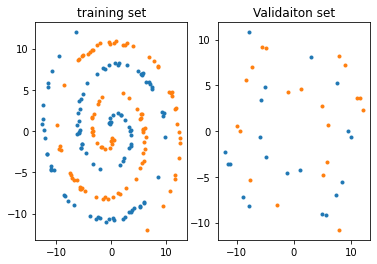

In [22]:
plt.subplot(1,2,1)
plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.subplot(1,2,2)
plt.title('Validaiton set')
plt.plot(X_test[y_test==0,0], X_test[y_test==0,1], '.')
plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], '.')
plt.show()

# Initializing Layers

In [23]:
y = y.reshape(-1,1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 128, weight_regularizer_l2=5e-4,
                     bias_regularizer_l2=5e-4)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

#dropout1 = Layer_Dropout(0.2)
dropout1 = Layer_NewDropout(0.2)

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense2 = Layer_Dense(128, 128)

activation2 = Activation_ReLU()

dense3 = Layer_Dense(128,1)

# Create Sigmoid activation:
activation3 = Activation_Sigmoid()

# Create loss function
loss_function = Loss_BinaryCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(decay=5e-7)

# Training Loop

In [24]:
epochs = 5000

for epoch in range(epochs + 1):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    if epoch != 0:
      #print('Found')
      cached_val_inputs = cached_val_inputs
      cached_train_inputs = activation1.output
    else:
      cached_val_inputs = np.random.random(size=128)
      cached_train_inputs = activation1.output
      #print(cached_val_inputs.shape)
      #print(activation1.output.shape)

    dropout1.forward(inputs=activation1.output, val_inputs=cached_val_inputs)
    #dropout1.forward(activation1.output)
    # def forward(self, inputs, model, X_test, y_test):

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function
    # of first layer as inputs
    dense2.forward(dropout1.output)

    # print(dense1.output.shape)
    cached_train_inputs = np.mean(activation1.output, axis=0)
    # print(activation1.output.shape)

    # dropout1.forward(dense1_outputs)

    # Perform a forward pass through activation function
    # takes the output of second dense layer here
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)

    activation3.forward(dense3.output)

    # Calculate the data loss
    data_loss = loss_function.calculate(activation3.output, y)
    # Calculate regularization penalty
    regularization_loss = \
        loss_function.regularization_loss(dense1) + \
        loss_function.regularization_loss(dense2) + \
        loss_function.regularization_loss(dense3)

    # Calculate overall loss
    loss = data_loss + regularization_loss

    predictions = np.round(activation3.output)
    accuracy = np.mean(predictions == y)

    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()
    dropout1.post_update_params()

    # Validation
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    # print(dense1.output.shape)
    dense1_outputs = dense1.output
    meanarray = np.mean(dense1.output, axis=0)
    #cached_val_inputs = activation1.output, axis=0)
    cached_val_inputs = activation1.output
    # print(cached_val_inputs.shape)
    # print(meanarray.shape)
    trainout = meanarray
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    # Calculate the data loss
    valloss = loss_function.calculate(activation3.output, y_test)
    predictions = np.round(activation3.output)
    valaccuracy = np.mean(predictions == y_test)

    #Unseen Validation
    dense1.forward(X_val)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    test_loss = loss_function.calculate(activation3.output, y_val)
    predictions = np.round(activation3.output)
    test_accuracy = np.mean(predictions == y_val)

    #Updating List
    loss_cache.append(loss)
    val_loss_cache.append(valloss)
    acc_cache.append(accuracy)
    val_acc_cache.append(valaccuracy)
    lr_cache.append(optimizer.current_learning_rate)
    epoch_cache.append(epoch)
    test_acc_cache.append(test_accuracy)
    test_loss_cache.append(test_loss)


    #Summary Items
    if valaccuracy >= .8 and len(summary) == 0:
        nintypercent = f'Model hit 80% accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .85 and len(summary) == 1:
        nintypercent = f'Model hit 85% accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .9 and len(summary) == 2:
        nintypercent = f'Model hit 90% accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .95 and len(summary) == 3:
        nintypercent = f'Model hit 95% accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .975 and len(summary) == 4:
        nintypercent = f'Model hit 97.5% accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if epoch == epochs:
      if valaccuracy > max_val_accuracyint:
        max_val_accuracyint = valaccuracy
        max_val_accuracy = f'Max accuracy was {valaccuracy * 100}% at epoch {epoch}.'
        summary.append(max_val_accuracy)
      else:
        summary.append(max_val_accuracy)
    else:
      if valaccuracy > max_val_accuracyint:
        max_val_accuracyint = valaccuracy
        max_val_accuracy = f'Max accuracy was {valaccuracy * 100}% at epoch {epoch}.'     
    
    if test_accuracy >= .999 and epoch >= 1000:
      print(f'Epoch: {epoch}')
      break

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate:.9f} ' +
              f'validation, acc: {valaccuracy:.3f}, loss: {valloss:.3f} ' +
              f'Unseen: acc: {test_accuracy:.3f} loss: {test_loss:.3f} ')

epoch: 0, acc: 0.490, loss: 0.693 (data_loss: 0.693, reg_loss: 0.000), lr: 0.020000000 validation, acc: 0.650, loss: 0.684 Unseen: acc: 0.593 loss: 0.686 
epoch: 100, acc: 0.815, loss: 0.453 (data_loss: 0.445, reg_loss: 0.008), lr: 0.019999000 validation, acc: 0.550, loss: 0.878 Unseen: acc: 0.664 loss: 0.684 
epoch: 200, acc: 0.970, loss: 0.112 (data_loss: 0.090, reg_loss: 0.021), lr: 0.019998000 validation, acc: 0.800, loss: 0.341 Unseen: acc: 0.876 loss: 0.254 
epoch: 300, acc: 0.935, loss: 0.193 (data_loss: 0.159, reg_loss: 0.034), lr: 0.019997000 validation, acc: 0.900, loss: 0.206 Unseen: acc: 0.922 loss: 0.136 
epoch: 400, acc: 0.975, loss: 0.115 (data_loss: 0.074, reg_loss: 0.041), lr: 0.019996001 validation, acc: 0.925, loss: 0.240 Unseen: acc: 0.953 loss: 0.168 
epoch: 500, acc: 1.000, loss: 0.056 (data_loss: 0.011, reg_loss: 0.046), lr: 0.019995001 validation, acc: 0.950, loss: 0.110 Unseen: acc: 0.973 loss: 0.090 
epoch: 600, acc: 0.950, loss: 0.166 (data_loss: 0.121, reg_l

# Summary

In [25]:
for milestone in summary:
  print(milestone)

Model hit 80% accuracy in 190 epochs
Model hit 85% accuracy in 191 epochs
Model hit 90% accuracy in 218 epochs
Model hit 95% accuracy in 218 epochs
Model hit 97.5% accuracy in 218 epochs


# Testing

Creating Testing Data


In [26]:
X_test, y_test = twospirals(2000)

Evaluating Testing Data

In [27]:
# Reshape labels to be a list of lists
# Inner list contains one output (either 0 or 1)
# per each output neuron, 1 in this case
y_test = y_test.reshape(-1, 1)

dense1.forward(X_test)

activation1.forward(dense1.output)

dense2.forward(activation1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

# Calculate the data loss
loss = loss_function.calculate(activation3.output, y_test)

predictions = np.round(activation3.output)
yy = np.round(activation3.output.T[0])
xx = np.round(X_test.T[0])
accuracy = np.mean(predictions == y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 1.000, loss: 0.025


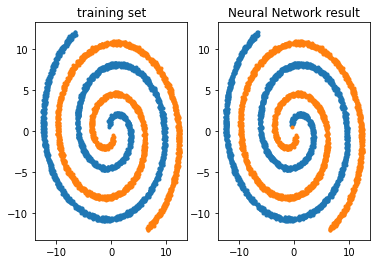

In [28]:
plt.subplot(1,2,1)
plt.title('training set')
plt.plot(X_test[y_test.T[0]==0,0], X_test[y_test.T[0]==0,1], '.')
plt.plot(X_test[y_test.T[0]==1,0], X_test[y_test.T[0]==1,1], '.')
plt.subplot(1,2,2)
plt.title('Neural Network result')
plt.plot(X_test[yy==0,0], X_test[yy==0,1], '.')
plt.plot(X_test[yy==1,0], X_test[yy==1,1], '.')
plt.show()

In [29]:
# probability decision surface for logistic regression on a binary classification dataset
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# generate dataset
X = X_test
y = y_test
# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y.ravel())
# make predictions for the grid
#print(grid.shape)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

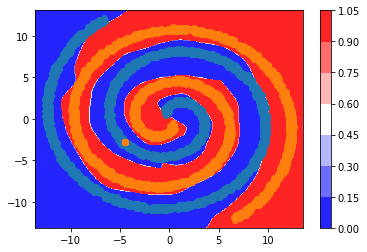

In [30]:
dense1.forward(grid)

activation1.forward(dense1.output)

dense2.forward(activation1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

yhat = np.round(activation3.output)

yhat = yhat[:, 0]
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='bwr')
# add a legend, called a color bar
plt.colorbar(c)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

Plotting Graphs

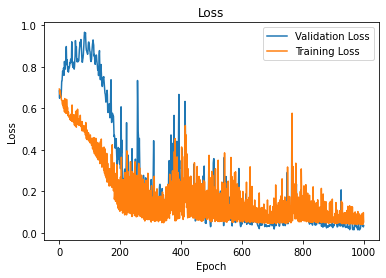

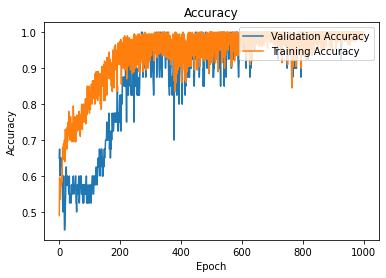

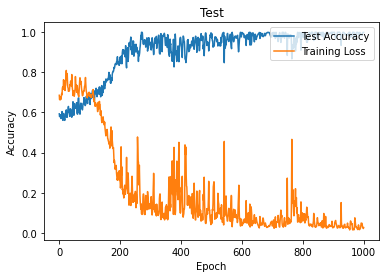

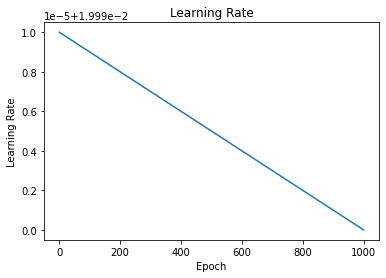

In [31]:
plt.plot(epoch_cache, val_loss_cache, label='Validation Loss')
plt.plot(epoch_cache, loss_cache, label='Training Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.show()

plt.plot(epoch_cache, val_acc_cache, label='Validation Accuracy')
plt.plot(epoch_cache, acc_cache, label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = "upper right")
plt.show()

plt.plot(epoch_cache, test_acc_cache, label='Test Accuracy')
plt.plot(epoch_cache, test_loss_cache, label='Training Loss')
plt.title('Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = "upper right")
plt.show()


plt.plot(epoch_cache, lr_cache, label='LR')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()